This notebook is to check the results from different epoch runs. This includes the following:
- Beta diversity
    - PCoA using Bray-curtis and Aitchison distances
    - NMDS and t-SNE as final plots
    - PERMANOVA analyses (significant for AD count, for rest just to make sure it doens't add bias)
- Alpha diversity
    - Kruskal-Wallis for multiple biological groups on ALL TAXA to extract significantly different OTUs
    - post-hoc Dunn's test for identifying which groups is significantly different
- Batch effect metrics (should be consistent across runs)
- cLISI and iLISI (to be computed, might take a long time for big datasets)

## Libraries

In [1]:
# Essentials
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import scipy.stats as stats
from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.multitest import multipletests
import numpy as np
import pandas as pd
import os
import re
import random
import seaborn as sns
# User libraries
from BatchEffectDataLoader import DataPreprocess, DataTransform, one_hot_encoding
from BatchEffectCorrection import correctCombat, correctLimma_rBE, correctBMC, correctPLSDAbatch_R, correctCombatSeq, correctConQuR
from BatchEffectPlots import plotPCA, plotPCoA, plot_LISI_perplexity
from BatchEffectMetrics import all_metrics, pairwise_distance, pairwise_distance_std, PERMANOVA, pairwise_distance_multi_run
from ABaCo import abaco_run, abaco_recon, contour_plot, abaco_run_ensemble, abaco_recon_ensemble

>> clustergrammer2 backend version 0.18.0


## PERMANOVA analysis

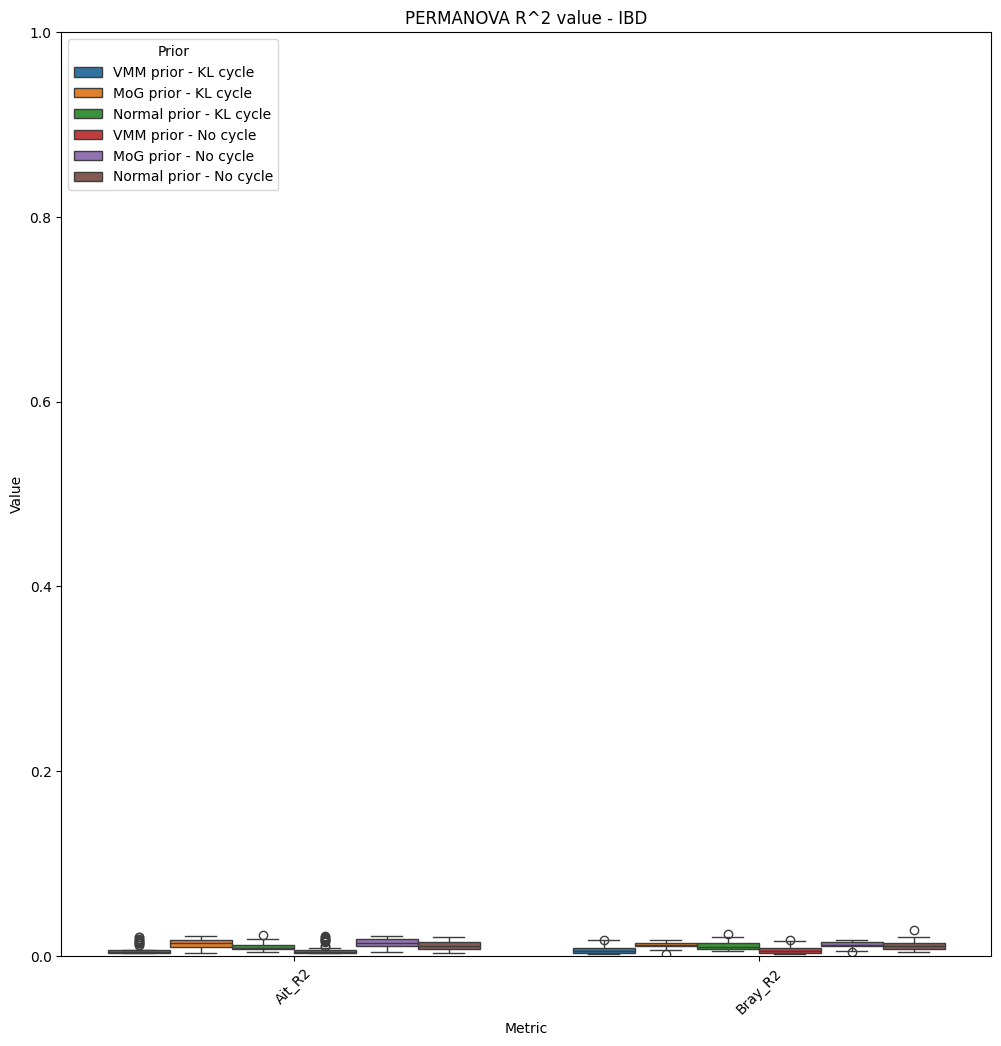

In [8]:
# KL CYCLE MODELS
# VMM models
ad_vmm_kl_perma_ait_path = "performance_metrics/deterministic/AD_count/VMM_KL_cycle_perma_ait.csv"
ad_vmm_kl_perma_brc_path = "performance_metrics/deterministic/AD_count/VMM_KL_cycle_perma_bc.csv"
ad_vmm_kl_perma_ait = pd.read_csv(ad_vmm_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_vmm_kl_perma_brc = pd.read_csv(ad_vmm_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_vmm_kl_perma = pd.concat([ad_vmm_kl_perma_ait, ad_vmm_kl_perma_brc], axis=1)

ibd_vmm_kl_perma_ait_path = "performance_metrics/deterministic/IBD/VMM_KL_cycle_perma_ait.csv"
ibd_vmm_kl_perma_brc_path = "performance_metrics/deterministic/IBD/VMM_KL_cycle_perma_bc.csv"
ibd_vmm_kl_perma_ait = pd.read_csv(ibd_vmm_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_vmm_kl_perma_brc = pd.read_csv(ibd_vmm_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_vmm_kl_perma = pd.concat([ibd_vmm_kl_perma_ait, ibd_vmm_kl_perma_brc], axis=1)

dtu_vmm_kl_perma_ait_path = "performance_metrics/deterministic/DTU-GE/VMM_KL_cycle_perma_ait.csv"
dtu_vmm_kl_perma_brc_path = "performance_metrics/deterministic/DTU-GE/VMM_KL_cycle_perma_bc.csv"
dtu_vmm_kl_perma_ait = pd.read_csv(dtu_vmm_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_vmm_kl_perma_brc = pd.read_csv(dtu_vmm_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_vmm_kl_perma = pd.concat([dtu_vmm_kl_perma_ait, dtu_vmm_kl_perma_brc], axis=1)


# MoG models
ad_mog_kl_perma_ait_path = "performance_metrics/deterministic/AD_count/MoG_KL_cycle_perma_ait.csv"
ad_mog_kl_perma_brc_path = "performance_metrics/deterministic/AD_count/MoG_KL_cycle_perma_bc.csv"
ad_mog_kl_perma_ait = pd.read_csv(ad_mog_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_mog_kl_perma_brc = pd.read_csv(ad_mog_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_mog_kl_perma = pd.concat([ad_mog_kl_perma_ait, ad_mog_kl_perma_brc], axis=1)

ibd_mog_kl_perma_ait_path = "performance_metrics/deterministic/IBD/MoG_KL_cycle_perma_ait.csv"
ibd_mog_kl_perma_brc_path = "performance_metrics/deterministic/IBD/MoG_KL_cycle_perma_bc.csv"
ibd_mog_kl_perma_ait = pd.read_csv(ibd_mog_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_mog_kl_perma_brc = pd.read_csv(ibd_mog_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_mog_kl_perma = pd.concat([ibd_mog_kl_perma_ait, ibd_mog_kl_perma_brc], axis=1)

dtu_mog_kl_perma_ait_path = "performance_metrics/deterministic/DTU-GE/MoG_KL_cycle_perma_ait.csv"
dtu_mog_kl_perma_brc_path = "performance_metrics/deterministic/DTU-GE/MoG_KL_cycle_perma_bc.csv"
dtu_mog_kl_perma_ait = pd.read_csv(dtu_mog_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_mog_kl_perma_brc = pd.read_csv(dtu_mog_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_mog_kl_perma = pd.concat([dtu_mog_kl_perma_ait, dtu_mog_kl_perma_brc], axis=1)

# Normal models
ad_std_kl_perma_ait_path = "performance_metrics/deterministic/AD_count/Std_KL_cycle_perma_ait.csv"
ad_std_kl_perma_brc_path = "performance_metrics/deterministic/AD_count/Std_KL_cycle_perma_bc.csv"
ad_std_kl_perma_ait = pd.read_csv(ad_std_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_std_kl_perma_brc = pd.read_csv(ad_std_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_std_kl_perma = pd.concat([ad_std_kl_perma_ait, ad_std_kl_perma_brc], axis=1)

ibd_std_kl_perma_ait_path = "performance_metrics/deterministic/IBD/Std_KL_cycle_perma_ait.csv"
ibd_std_kl_perma_brc_path = "performance_metrics/deterministic/IBD/Std_KL_cycle_perma_bc.csv"
ibd_std_kl_perma_ait = pd.read_csv(ibd_std_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_std_kl_perma_brc = pd.read_csv(ibd_std_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_std_kl_perma = pd.concat([ibd_std_kl_perma_ait, ibd_std_kl_perma_brc], axis=1)

dtu_std_kl_perma_ait_path = "performance_metrics/deterministic/DTU-GE/Std_KL_cycle_perma_ait.csv"
dtu_std_kl_perma_brc_path = "performance_metrics/deterministic/DTU-GE/Std_KL_cycle_perma_bc.csv"
dtu_std_kl_perma_ait = pd.read_csv(dtu_std_kl_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_std_kl_perma_brc = pd.read_csv(dtu_std_kl_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_std_kl_perma = pd.concat([dtu_std_kl_perma_ait, dtu_std_kl_perma_brc], axis=1)

# NO CYCLE MODELS
# VMM models
ad_vmm_no_perma_ait_path = "performance_metrics/deterministic/AD_count/VMM_no_cycle_perma_ait.csv"
ad_vmm_no_perma_brc_path = "performance_metrics/deterministic/AD_count/VMM_no_cycle_perma_bc.csv"
ad_vmm_no_perma_ait = pd.read_csv(ad_vmm_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_vmm_no_perma_brc = pd.read_csv(ad_vmm_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_vmm_no_perma = pd.concat([ad_vmm_no_perma_ait, ad_vmm_no_perma_brc], axis=1)

ibd_vmm_no_perma_ait_path = "performance_metrics/deterministic/IBD/VMM_no_cycle_perma_ait.csv"
ibd_vmm_no_perma_brc_path = "performance_metrics/deterministic/IBD/VMM_no_cycle_perma_bc.csv"
ibd_vmm_no_perma_ait = pd.read_csv(ibd_vmm_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_vmm_no_perma_brc = pd.read_csv(ibd_vmm_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_vmm_no_perma = pd.concat([ibd_vmm_no_perma_ait, ibd_vmm_no_perma_brc], axis=1)

dtu_vmm_no_perma_ait_path = "performance_metrics/deterministic/DTU-GE/VMM_no_cycle_perma_ait.csv"
dtu_vmm_no_perma_brc_path = "performance_metrics/deterministic/DTU-GE/VMM_no_cycle_perma_bc.csv"
dtu_vmm_no_perma_ait = pd.read_csv(dtu_vmm_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_vmm_no_perma_brc = pd.read_csv(dtu_vmm_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_vmm_no_perma = pd.concat([dtu_vmm_no_perma_ait, dtu_vmm_no_perma_brc], axis=1)

# MoG models
ad_mog_no_perma_ait_path = "performance_metrics/deterministic/AD_count/MoG_no_cycle_perma_ait.csv"
ad_mog_no_perma_brc_path = "performance_metrics/deterministic/AD_count/MoG_no_cycle_perma_bc.csv"
ad_mog_no_perma_ait = pd.read_csv(ad_mog_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_mog_no_perma_brc = pd.read_csv(ad_mog_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_mog_no_perma = pd.concat([ad_mog_no_perma_ait, ad_mog_no_perma_brc], axis=1)

ibd_mog_no_perma_ait_path = "performance_metrics/deterministic/IBD/MoG_no_cycle_perma_ait.csv"
ibd_mog_no_perma_brc_path = "performance_metrics/deterministic/IBD/MoG_no_cycle_perma_bc.csv"
ibd_mog_no_perma_ait = pd.read_csv(ibd_mog_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_mog_no_perma_brc = pd.read_csv(ibd_mog_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_mog_no_perma = pd.concat([ibd_mog_no_perma_ait, ibd_mog_no_perma_brc], axis=1)

dtu_mog_no_perma_ait_path = "performance_metrics/deterministic/DTU-GE/MoG_no_cycle_perma_ait.csv"
dtu_mog_no_perma_brc_path = "performance_metrics/deterministic/DTU-GE/MoG_no_cycle_perma_bc.csv"
dtu_mog_no_perma_ait = pd.read_csv(dtu_mog_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_mog_no_perma_brc = pd.read_csv(dtu_mog_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_mog_no_perma = pd.concat([dtu_mog_no_perma_ait, dtu_mog_no_perma_brc], axis=1)

# Normal models
ad_std_no_perma_ait_path = "performance_metrics/deterministic/AD_count/Std_no_cycle_perma_ait.csv"
ad_std_no_perma_brc_path = "performance_metrics/deterministic/AD_count/Std_no_cycle_perma_bc.csv"
ad_std_no_perma_ait = pd.read_csv(ad_std_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ad_std_no_perma_brc = pd.read_csv(ad_std_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ad_std_no_perma = pd.concat([ad_std_no_perma_ait, ad_std_no_perma_brc], axis=1)

ibd_std_no_perma_ait_path = "performance_metrics/deterministic/IBD/Std_no_cycle_perma_ait.csv"
ibd_std_no_perma_brc_path = "performance_metrics/deterministic/IBD/Std_no_cycle_perma_bc.csv"
ibd_std_no_perma_ait = pd.read_csv(ibd_std_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
ibd_std_no_perma_brc = pd.read_csv(ibd_std_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
ibd_std_no_perma = pd.concat([ibd_std_no_perma_ait, ibd_std_no_perma_brc], axis=1)

dtu_std_no_perma_ait_path = "performance_metrics/deterministic/DTU-GE/Std_no_cycle_perma_ait.csv"
dtu_std_no_perma_brc_path = "performance_metrics/deterministic/DTU-GE/Std_no_cycle_perma_bc.csv"
dtu_std_no_perma_ait = pd.read_csv(dtu_std_no_perma_ait_path, usecols=["R2"]).rename(columns={"R2":"Ait_R2"})
dtu_std_no_perma_brc = pd.read_csv(dtu_std_no_perma_brc_path, usecols=["R2"]).rename(columns={"R2":"Bray_R2"})
dtu_std_no_perma = pd.concat([dtu_std_no_perma_ait, dtu_std_no_perma_brc], axis=1)

# Build boxplot with results
ad_vmm_kl_perma['iter'] = 'VMM prior - KL cycle'
ad_mog_kl_perma['iter'] = 'MoG prior - KL cycle'
ad_std_kl_perma['iter'] = 'Normal prior - KL cycle'
ad_vmm_no_perma['iter'] = 'VMM prior - No cycle'
ad_mog_no_perma['iter'] = 'MoG prior - No cycle'
ad_std_no_perma['iter'] = 'Normal prior - No cycle'

ibd_vmm_kl_perma['iter'] = 'VMM prior - KL cycle'
ibd_mog_kl_perma['iter'] = 'MoG prior - KL cycle'
ibd_std_kl_perma['iter'] = 'Normal prior - KL cycle'
ibd_vmm_no_perma['iter'] = 'VMM prior - No cycle'
ibd_mog_no_perma['iter'] = 'MoG prior - No cycle'
ibd_std_no_perma['iter'] = 'Normal prior - No cycle'

dtu_vmm_kl_perma['iter'] = 'VMM prior - KL cycle'
dtu_mog_kl_perma['iter'] = 'MoG prior - KL cycle'
dtu_std_kl_perma['iter'] = 'Normal prior - KL cycle'
dtu_vmm_no_perma['iter'] = 'VMM prior - No cycle'
dtu_mog_no_perma['iter'] = 'MoG prior - No cycle'
dtu_std_no_perma['iter'] = 'Normal prior - No cycle'

# Combine into one dataframe
ad_combined_batch_df_perma = pd.concat([ad_vmm_kl_perma, ad_mog_kl_perma, ad_std_kl_perma,
                                     ad_vmm_no_perma, ad_mog_no_perma, ad_std_no_perma])
ad_melted_perma = ad_combined_batch_df_perma.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

ibd_combined_batch_df_perma = pd.concat([ibd_vmm_kl_perma, ibd_mog_kl_perma, ibd_std_kl_perma,
                                         ibd_vmm_no_perma, ibd_mog_no_perma, ibd_std_no_perma])
ibd_melted_perma = ibd_combined_batch_df_perma.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

dtu_combined_batch_df_perma = pd.concat([dtu_vmm_kl_perma, dtu_mog_kl_perma, dtu_std_kl_perma,
                                         dtu_vmm_no_perma, dtu_mog_no_perma, dtu_std_no_perma])
dtu_melted_perma = dtu_combined_batch_df_perma.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

# Create subplots side by side
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

# sns.boxplot(
#     data=ad_melted_perma,
#     x='Metric',
#     y='Value',
#     hue='iter',
#     ax=axes[0]
# )

# axes[0].set_title('PERMANOVA R^2 value - AD Count')
# axes[0].tick_params(axis='x', rotation=45)
# axes[0].legend(title='Prior', loc='lower left')

sns.boxplot(
    data=ibd_melted_perma,
    x='Metric',
    y='Value',
    hue='iter',
    ax=axes,
)

axes.set_title('PERMANOVA R^2 value - IBD')
axes.set_ylim([0, 1])
axes.tick_params(axis='x', rotation=45)
axes.legend(title='Prior', loc='upper left')

# sns.boxplot(
#     data=dtu_melted_perma,
#     x='Metric',
#     y='Value',
#     hue='iter',
#     ax=axes[2]
# )

# axes[2].set_title('PERMANOVA R^2 value - DTU-GE')
# axes[2].tick_params(axis='x', rotation=45)
# axes[2].legend(title='Prior', loc='upper left')

## Batch correction metrics

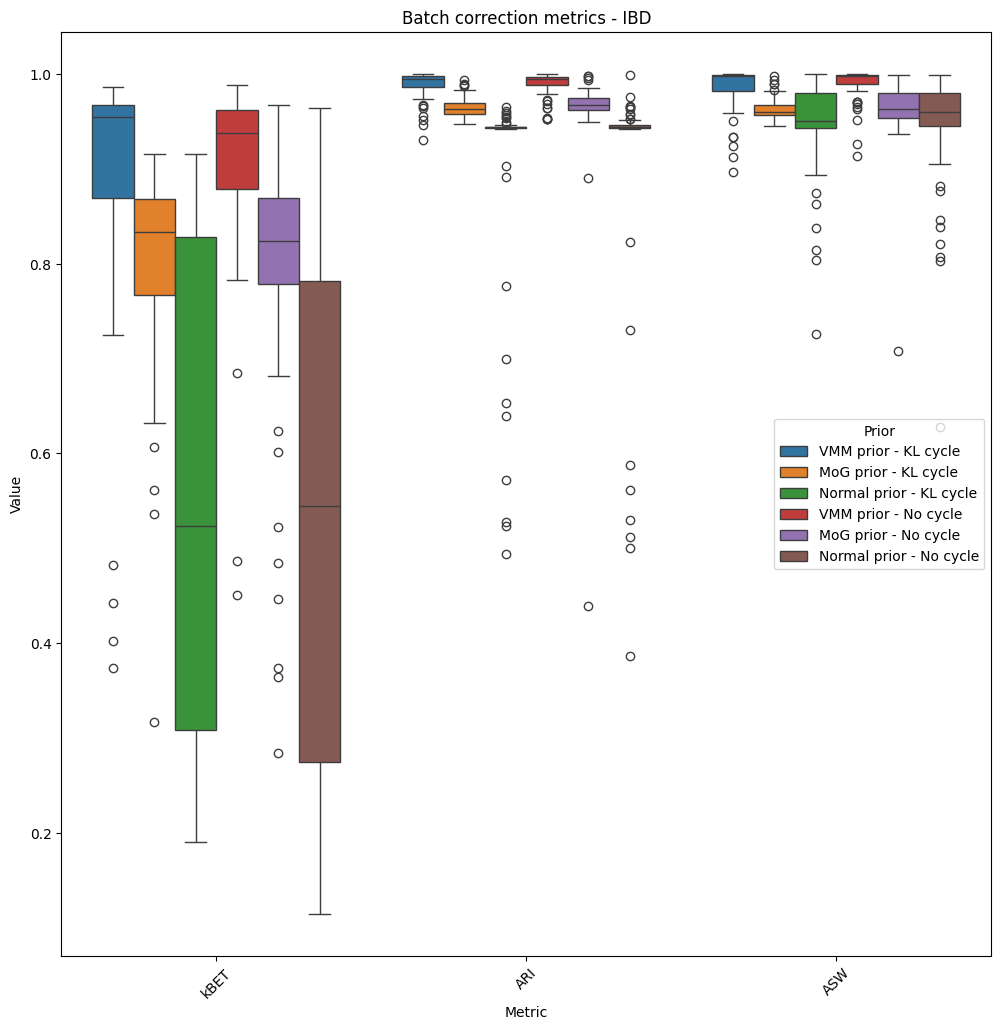

In [7]:
# Load saved metrics from previous runs
ad_path = "performance_metrics/deterministic/AD_count/"
ad_batch_vmm_kl = pd.read_csv(f"{ad_path}VMM_KL_cycle_batch.csv")
ad_batch_mog_kl = pd.read_csv(f"{ad_path}MoG_KL_cycle_batch.csv")
ad_batch_std_kl = pd.read_csv(f"{ad_path}Std_KL_cycle_batch.csv")
ad_batch_vmm_no = pd.read_csv(f"{ad_path}VMM_no_cycle_batch.csv")
ad_batch_mog_no = pd.read_csv(f"{ad_path}MoG_no_cycle_batch.csv")
ad_batch_std_no = pd.read_csv(f"{ad_path}Std_no_cycle_batch.csv")

ibd_path = "performance_metrics/deterministic/IBD/"
ibd_batch_vmm_kl = pd.read_csv(f"{ibd_path}VMM_KL_cycle_batch.csv")
ibd_batch_mog_kl = pd.read_csv(f"{ibd_path}MoG_KL_cycle_batch.csv")
ibd_batch_std_kl = pd.read_csv(f"{ibd_path}Std_KL_cycle_batch.csv")
ibd_batch_vmm_no = pd.read_csv(f"{ibd_path}VMM_no_cycle_batch.csv")
ibd_batch_mog_no = pd.read_csv(f"{ibd_path}MoG_no_cycle_batch.csv")
ibd_batch_std_no = pd.read_csv(f"{ibd_path}Std_no_cycle_batch.csv")

dtu_path = "performance_metrics/deterministic/DTU-GE/"
dtu_batch_vmm_kl = pd.read_csv(f"{dtu_path}VMM_KL_cycle_batch.csv")
dtu_batch_mog_kl = pd.read_csv(f"{dtu_path}MoG_KL_cycle_batch.csv")
dtu_batch_std_kl = pd.read_csv(f"{dtu_path}Std_KL_cycle_batch.csv")
dtu_batch_vmm_no = pd.read_csv(f"{dtu_path}VMM_no_cycle_batch.csv")
dtu_batch_mog_no = pd.read_csv(f"{dtu_path}MoG_no_cycle_batch.csv")
dtu_batch_std_no = pd.read_csv(f"{dtu_path}Std_no_cycle_batch.csv")

# Build boxplot with results
ad_batch_vmm_kl['iter'] = 'VMM prior - KL cycle'
ad_batch_mog_kl['iter'] = 'MoG prior - KL cycle'
ad_batch_std_kl['iter'] = 'Normal prior - KL cycle'
ad_batch_vmm_no['iter'] = 'VMM prior - No cycle'
ad_batch_mog_no['iter'] = 'MoG prior - No cycle'
ad_batch_std_no['iter'] = 'Normal prior - No cycle'

ibd_batch_vmm_kl['iter'] = 'VMM prior - KL cycle'
ibd_batch_mog_kl['iter'] = 'MoG prior - KL cycle'
ibd_batch_std_kl['iter'] = 'Normal prior - KL cycle'
ibd_batch_vmm_no['iter'] = 'VMM prior - No cycle'
ibd_batch_mog_no['iter'] = 'MoG prior - No cycle'
ibd_batch_std_no['iter'] = 'Normal prior - No cycle'

dtu_batch_vmm_kl['iter'] = 'VMM prior - KL cycle'
dtu_batch_mog_kl['iter'] = 'MoG prior - KL cycle'
dtu_batch_std_kl['iter'] = 'Normal prior - KL cycle'
dtu_batch_vmm_no['iter'] = 'VMM prior - No cycle'
dtu_batch_mog_no['iter'] = 'MoG prior - No cycle'
dtu_batch_std_no['iter'] = 'Normal prior - No cycle'

# Correct ARI and ASW metrics for batch correction (Closer to 0.5 is the best)
ad_batch_vmm_kl['ARI'] = 1 - abs(2*ad_batch_vmm_kl['ARI'] - 1)
ad_batch_vmm_kl['ASW'] = 1 - abs(2*ad_batch_vmm_kl['ASW'] - 1)
ad_batch_mog_kl['ARI'] = 1 - abs(2*ad_batch_mog_kl['ARI'] - 1)
ad_batch_mog_kl['ASW'] = 1 - abs(2*ad_batch_mog_kl['ASW'] - 1)
ad_batch_std_kl['ARI'] = 1 - abs(2*ad_batch_std_kl['ARI'] - 1)
ad_batch_std_kl['ASW'] = 1 - abs(2*ad_batch_std_kl['ASW'] - 1)
ad_batch_vmm_no['ARI'] = 1 - abs(2*ad_batch_vmm_no['ARI'] - 1)
ad_batch_vmm_no['ASW'] = 1 - abs(2*ad_batch_vmm_no['ASW'] - 1)
ad_batch_mog_no['ARI'] = 1 - abs(2*ad_batch_mog_no['ARI'] - 1)
ad_batch_mog_no['ASW'] = 1 - abs(2*ad_batch_mog_no['ASW'] - 1)
ad_batch_std_no['ARI'] = 1 - abs(2*ad_batch_std_no['ARI'] - 1)
ad_batch_std_no['ASW'] = 1 - abs(2*ad_batch_std_no['ASW'] - 1)

ibd_batch_vmm_kl['ARI'] = 1 - abs(2*ibd_batch_vmm_kl['ARI'] - 1)
ibd_batch_vmm_kl['ASW'] = 1 - abs(2*ibd_batch_vmm_kl['ASW'] - 1)
ibd_batch_mog_kl['ARI'] = 1 - abs(2*ibd_batch_mog_kl['ARI'] - 1)
ibd_batch_mog_kl['ASW'] = 1 - abs(2*ibd_batch_mog_kl['ASW'] - 1)
ibd_batch_std_kl['ARI'] = 1 - abs(2*ibd_batch_std_kl['ARI'] - 1)
ibd_batch_std_kl['ASW'] = 1 - abs(2*ibd_batch_std_kl['ASW'] - 1)
ibd_batch_vmm_no['ARI'] = 1 - abs(2*ibd_batch_vmm_no['ARI'] - 1)
ibd_batch_vmm_no['ASW'] = 1 - abs(2*ibd_batch_vmm_no['ASW'] - 1)
ibd_batch_mog_no['ARI'] = 1 - abs(2*ibd_batch_mog_no['ARI'] - 1)
ibd_batch_mog_no['ASW'] = 1 - abs(2*ibd_batch_mog_no['ASW'] - 1)
ibd_batch_std_no['ARI'] = 1 - abs(2*ibd_batch_std_no['ARI'] - 1)
ibd_batch_std_no['ASW'] = 1 - abs(2*ibd_batch_std_no['ASW'] - 1)

dtu_batch_vmm_kl['ARI'] = 1 - abs(2*dtu_batch_vmm_kl['ARI'] - 1)
dtu_batch_vmm_kl['ASW'] = 1 - abs(2*dtu_batch_vmm_kl['ASW'] - 1)
dtu_batch_mog_kl['ARI'] = 1 - abs(2*dtu_batch_mog_kl['ARI'] - 1)
dtu_batch_mog_kl['ASW'] = 1 - abs(2*dtu_batch_mog_kl['ASW'] - 1)
dtu_batch_std_kl['ARI'] = 1 - abs(2*dtu_batch_std_kl['ARI'] - 1)
dtu_batch_std_kl['ASW'] = 1 - abs(2*dtu_batch_std_kl['ASW'] - 1)
dtu_batch_vmm_no['ARI'] = 1 - abs(2*dtu_batch_vmm_no['ARI'] - 1)
dtu_batch_vmm_no['ASW'] = 1 - abs(2*dtu_batch_vmm_no['ASW'] - 1)
dtu_batch_mog_no['ARI'] = 1 - abs(2*dtu_batch_mog_no['ARI'] - 1)
dtu_batch_mog_no['ASW'] = 1 - abs(2*dtu_batch_mog_no['ASW'] - 1)
dtu_batch_std_no['ARI'] = 1 - abs(2*dtu_batch_std_no['ARI'] - 1)
dtu_batch_std_no['ASW'] = 1 - abs(2*dtu_batch_std_no['ASW'] - 1)

# Combine into one dataframe
ad_combined_batch_df = pd.concat([ad_batch_vmm_kl, ad_batch_mog_kl, ad_batch_std_kl,
                                  ad_batch_vmm_no, ad_batch_mog_no, ad_batch_std_no])

ibd_combined_batch_df = pd.concat([ibd_batch_vmm_kl, ibd_batch_mog_kl, ibd_batch_std_kl,
                                  ibd_batch_vmm_no, ibd_batch_mog_no, ibd_batch_std_no])

dtu_combined_batch_df = pd.concat([dtu_batch_vmm_kl, dtu_batch_mog_kl, dtu_batch_std_kl,
                                  dtu_batch_vmm_no, dtu_batch_mog_no, dtu_batch_std_no])

# Melt the dataframes to long format
ad_melted_batch = ad_combined_batch_df.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

ibd_melted_batch = ibd_combined_batch_df.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

dtu_melted_batch = dtu_combined_batch_df.melt(
    id_vars='iter', var_name='Metric', value_name='Value'
)

# Create subplots side by side
fig, axes = plt.subplots(1, 1, figsize=(12, 12), sharey=True)

# # Batch subplot
# sns.boxplot(
#     data=ad_melted_batch,
#     x='Metric',
#     y='Value',
#     hue='iter',
#     ax=axes[0]
# )
# axes[0].set_title('Batch correction metrics - AD Count')
# axes[0].tick_params(axis='x', rotation=45)
# axes[0].legend(title='Prior', loc='right')

# Batch subplot
sns.boxplot(
    data=ibd_melted_batch,
    x='Metric',
    y='Value',
    hue='iter',
    ax=axes
)
axes.set_title('Batch correction metrics - IBD')
axes.tick_params(axis='x', rotation=45)
axes.legend(title='Prior', loc='right')

# # Batch subplot
# sns.boxplot(
#     data=dtu_melted_batch,
#     x='Metric',
#     y='Value',
#     hue='iter',
#     ax=axes[2]
# )
# axes[2].set_title('Batch correction metrics - DTU-GE')
# axes[2].tick_params(axis='x', rotation=45)
# axes[2].legend(title='Prior', loc='right')

## Top taxomoic groups comparison between runs

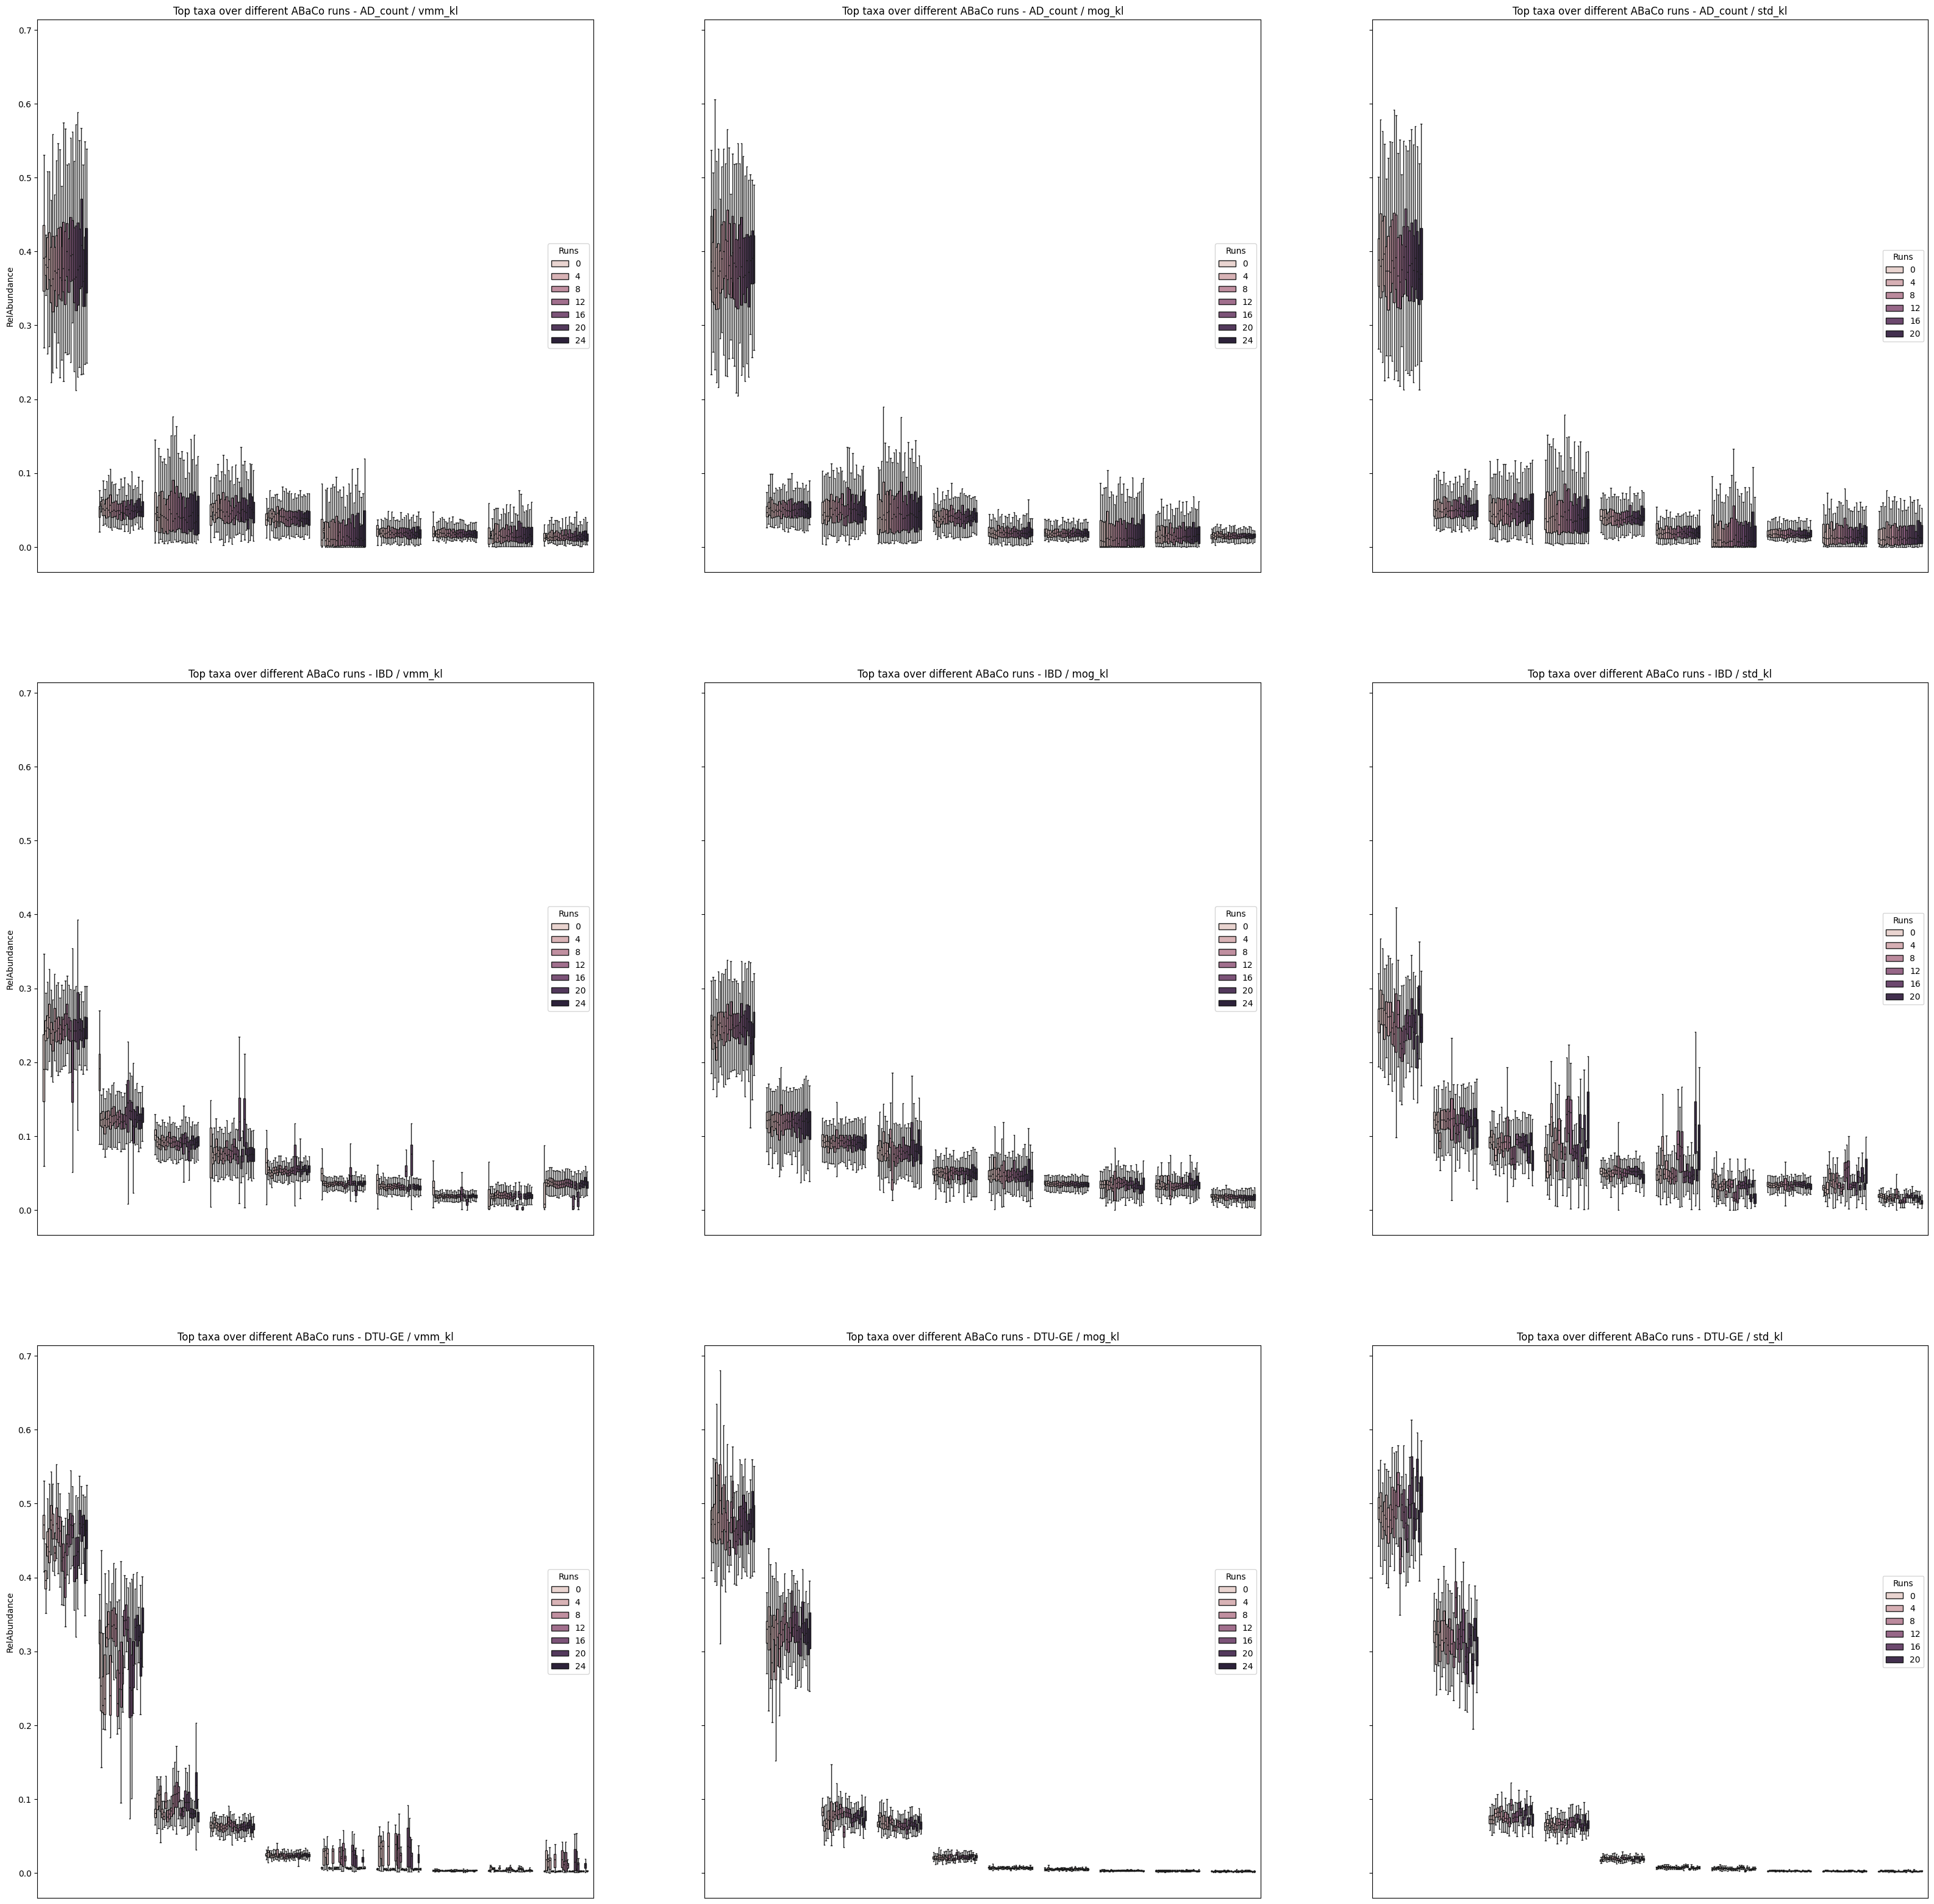

In [ ]:
mult = 21i
priors = ["vmm_kl", "mog_kl", "std_kl"]
datasets = ["AD_count", "IBD", "DTU-GE"]

# Build boxplot
fig, axes = plt.subplots(3, 3, figsize=(40, 40), sharey=True)

for k, prior in enumerate(priors):
    for j, dataset in enumerate(datasets):
        folder = f"performance_metrics/multi_runs/{dataset}"

        file_paths = [os.path.join(folder, file) 
                    for file in os.listdir(folder) 
                    if file.startswith(prior) and 
                    os.path.isfile(os.path.join(folder, file)) and
                    int(re.search(r"\d+$", file).group()) % mult == 0]

        ad_runs = []

        for file in file_paths:
            ad_runs.append(pd.read_csv(file))

        top10_taxa = pd.DataFrame()


        for i, run in enumerate(ad_runs):
            # 1. Compute relative abundances for run
            count_corr = run.select_dtypes(include="number")
            rel_corr = count_corr.div(count_corr.sum(axis=1), axis=0)

            # 2. Identify top 10 OTUs by mean relative abundance in the first run (using it as reference)
            if i == 0:
                top10 = rel_corr.mean().sort_values(ascending=False).head(10).index

            # 3. Subset and reshape to long form, adding a 'Dataset' column
            df_corr = (
                rel_corr[top10]
                .reset_index()
                .melt(
                    id_vars="index", value_vars=top10, var_name="OTU", value_name="RelAbundance"
                )
            )
            df_corr["iter"] = i

            # 4. Concatenate
            top10_taxa = pd.concat([top10_taxa, df_corr], ignore_index=True).reset_index(drop=True)

        # Batch subplot
        sns.boxplot(
            data=top10_taxa,
            x='OTU',
            y='RelAbundance',
            hue='iter',
            ax=axes[j][k],
            showfliers=False,
        )
        axes[j][k].set_title(f'Top taxa over different ABaCo runs - {dataset} / {prior}')
        axes[j][k].tick_params(axis='x', rotation=45)
        axes[j][k].legend(title='Runs', loc='right')
        axes[j][k].get_xaxis().set_visible(False)

## Kruskall-Wallis among biological groups per taxa

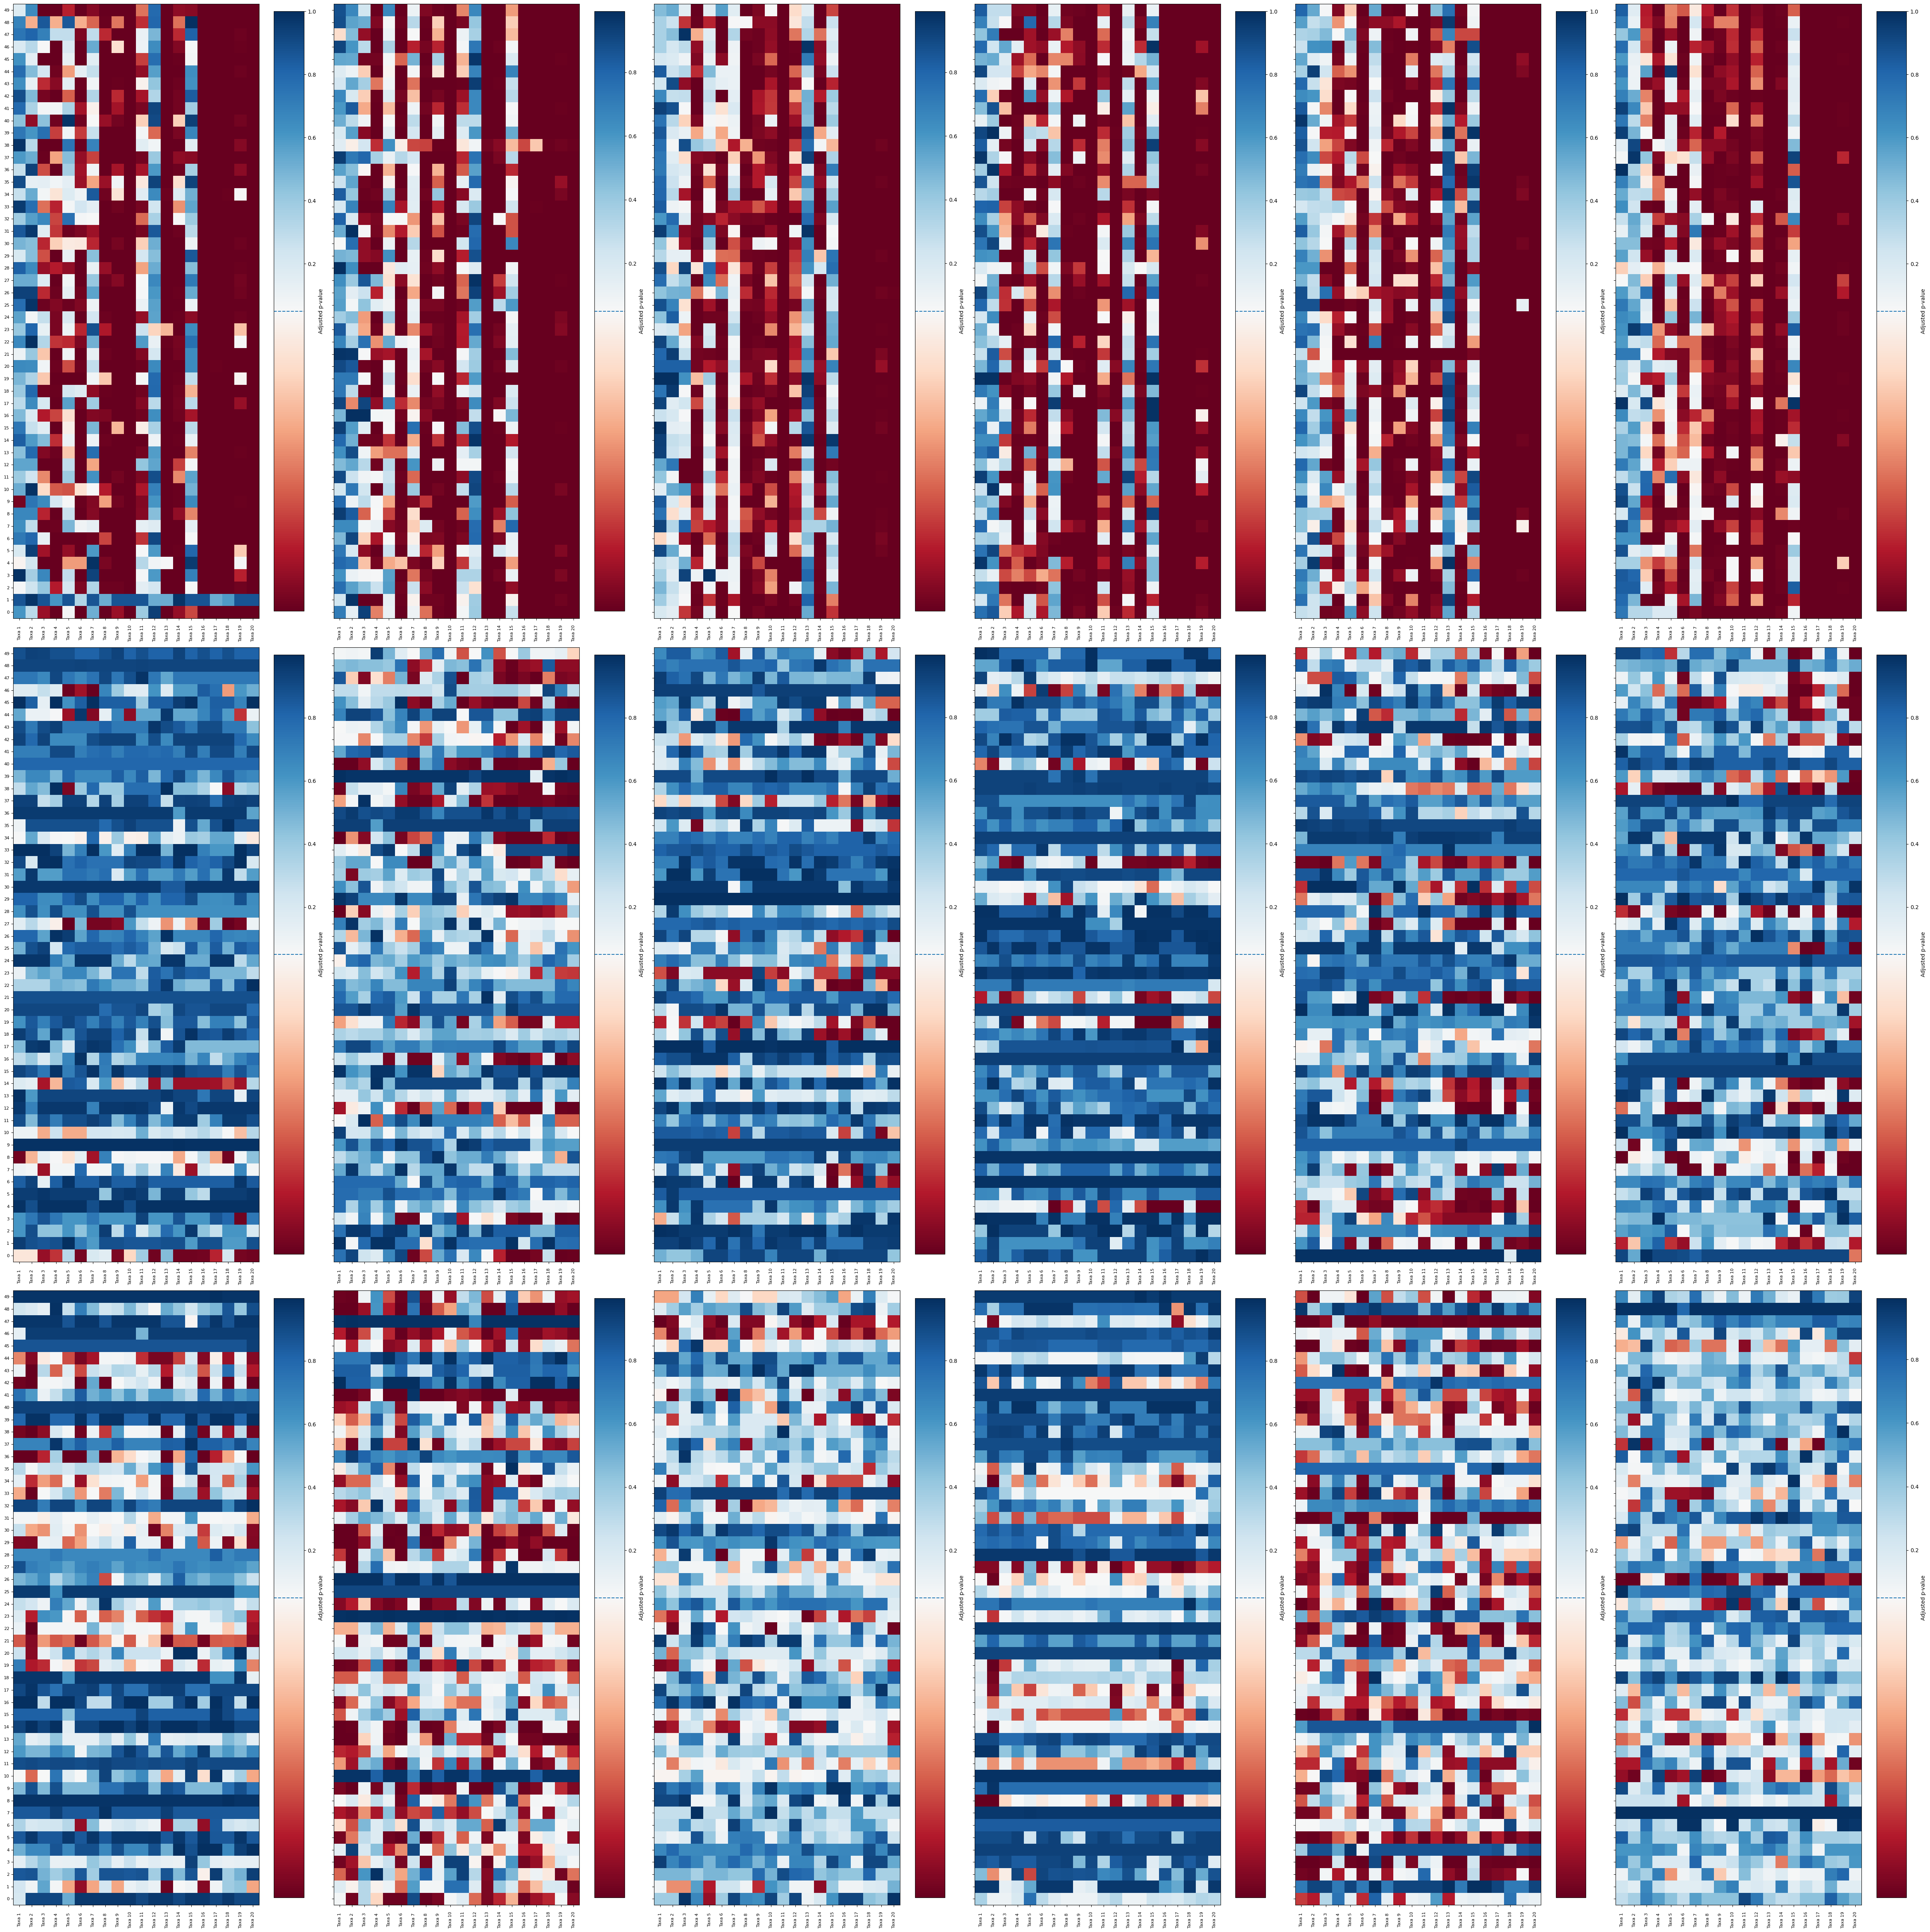

In [105]:
datasets = ["AD_count", "IBD", "DTU-GE"]
priors = ["vmm_kl", "mog_kl", "std_kl", "vmm_no", "mog_no", "std_no"]
mult = 1
bio_label = ["trt", "associated phenotype", "location"]
sample_label = ["sample", "run ID", "accession"]
batch_label = ["batch", "project ID", "pipeline"]

# Build boxplot
fig, axes = plt.subplots(3, 6, figsize=(50, 50), sharey=True)

for k, prior in enumerate(priors):
    for j, dataset in enumerate(datasets):
        folder = f"performance_metrics/multi_runs/{dataset}"

        # 1. Load data
        file_paths = [os.path.join(folder, file) 
                        for file in os.listdir(folder) 
                        if file.startswith(prior) and 
                        os.path.isfile(os.path.join(folder, file)) and
                        int(re.search(r"\d+$", file).group()) % mult == 0]

        ad_runs = []

        for i, file in enumerate(file_paths):
            # ad_run = pd.read_csv(file)
            ad_run = DataPreprocess(path = file, factors = [sample_label[j], batch_label[j], bio_label[j]])
            # Count to relative abundance for comparison of samples - only top 10 taxa
            count_cols = ad_run.select_dtypes(include="number").columns
            rel_counts = ad_run[count_cols].div(ad_run[count_cols].sum(axis=1), axis=0)

            if i == 0:
                top10 = rel_counts.mean(axis=0).sort_values(ascending=False).index[:20]

            taxa_cols = count_cols.intersection(top10)
            taxa_counts = rel_counts[taxa_cols]
            ad_run[taxa_cols] = taxa_counts
            # Drop all other taxa
            non_num = ad_run.select_dtypes(exclude="number").columns
            ad_run = ad_run[list(non_num) + list(taxa_cols)]
            # Append dataframe
            ad_runs.append(ad_run)

        # 2. Compute Kruskal-Wallis per taxonomic group between each biological group
        multi_kw_df = pd.DataFrame()
        for i, run in enumerate(ad_runs):

            melt_df = pd.melt(run, id_vars = [sample_label[j], batch_label[j], bio_label[j]], var_name = "taxa", value_name = "RelAbundance")
            
            results = []
            # Per taxa
            for taxon, df_taxa in melt_df.groupby("taxa"):
                # For each biological group
                groups = []

                for grp, df_grp in df_taxa.groupby(bio_label[j]):

                    groups.append(df_grp["RelAbundance"].values)

                try:
                    stat, pval = kruskal(*groups)
                    
                except ValueError:
                    continue

                results.append({"taxa":taxon,
                                "H_stat":stat,
                                "p-value":pval})
            
            kw_df = pd.DataFrame(results)

            rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
            kw_df["p_adj"] = p_adj
            kw_df["significant"] = rej
            kw_df["iter"] = i
            multi_kw_df = pd.concat([multi_kw_df, kw_df], axis = 0).reset_index(drop=True)

        # 3. Create subplot per prior distribution
        heat_df = multi_kw_df.pivot(index="iter", columns="taxa", values="p_adj")

        vmin = heat_df.min().min()
        vmax = heat_df.max().max()
        mid = 0.05

        norm = TwoSlopeNorm(vmin = vmin, vcenter = mid, vmax = vmax)
        cmap = plt.get_cmap("RdBu")

        n_rows, n_cols = heat_df.shape

        x = np.arange(n_cols + 1)
        y = np.arange(n_rows + 1)

        cell_size = 0.3
        fig_width  = n_cols * cell_size
        fig_height = n_rows * cell_size

        ax = axes[j,k]

        im = ax.pcolormesh(
            x, y, heat_df.values, 
            norm=norm,
            cmap=cmap,
            shading="flat")

        n_cols = heat_df.shape[1]
        generic_labels = [f"Taxa {i+1}" for i in range(n_cols)]
        ax.set_xticks(np.arange(n_cols) + 0.5)
        ax.set_xticklabels(generic_labels, rotation=90, va='center', fontsize=8)

        ax.set_yticks(np.arange(n_rows) + 0.5)
        ax.set_yticklabels(heat_df.index, fontsize=8)
        ax.set_aspect('equal')
        ax.tick_params(axis='x', which='major', pad=24)

        cbar = fig.colorbar(im, ax=ax, fraction=0.1)
        cbar.set_label('Adjusted p-value')
        cbar.ax.hlines(mid, *cbar.ax.get_xlim(), linestyles='--')

plt.tight_layout()
plt.show()